# OTUS Ablation Study Paper Plots | $p p > t \bar{t}$

This notebook creates the plots which are found in the paper: https://arxiv.org/abs/2101.08944. 

# Load Required Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
from scipy import stats

# Add utilityFunctions/ to easily use utility .py files
import sys
sys.path.append("../../utilityFunctions")

# Meta Parameters

In [2]:
#-- Set appropriate lambda value --#
# allLambs    = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
selectLambs = [0.001, 10, 100]
lamb = selectLambs[0]
print('lamb = ', lamb)

lamb =  0.001


In [3]:
save_figs = True  # Global switch to turn on saving figures to files
N_slices  = 1000  # Global number of slices to calculate SW distance with

data_directory    = '../../data/'
dataset_name      = 'ppttbar'
results_dataPath  = '../../experiments/'+dataset_name+f'/ablationStudy/lambda_tuning/npzFiles/swae-lamb={lamb}.npz'
img_dir           = dataset_name+'_lambTuningImages/'

np.random.seed(4) # Set numpy random seed

# Get Truth Datasets and Model Results

The data was split into training, validation, and two testing sets. We load only the validation dataset here and split it in two. We also load in the model results calculated on one of the validation datasets.

Note that we have two separate validation sets to ensure the independence of samples when performing statistical tests.

Specifically, we have 4 initial datasets: x_val1, z_val1, x_val2, and z_val2.

Validation set 1 has been used to obtain network results. These results will be compared to the independent validation set 2.

For testing the encoder's performance we will use the following convention:
- z_pred_val1 = E(x_val1, $\epsilon$)

In plots this will be denoted as $x \rightarrow \tilde{z}$.

For testing the decoder's performance we will use the following convention:
- x_pred_truth_val1 = D(z_val1, $\epsilon$)

In plots this will be denoted as $z \rightarrow \tilde{x}'$.

For testing the overall performance of the full encoder-decoder chain we will use the following convention:
- x_pred_val1 = D(E(x_val1, $\epsilon$), $\epsilon$)

In plots this will be denoted as $x \rightarrow \tilde{z} \rightarrow \tilde{x}$.

Note that $\epsilon$ denotes the random noise input of the networks. Note that all $\epsilon$ are different random samples. This happens internally and thus won't be shown in what follows.

## Load in Validation Data and Results

In [4]:
valData = np.load(results_dataPath)

#-- Load truth data --#
zData = valData['z']
xData = valData['x']

#-- Split data into the two separate validation sets --#
f = int(0.5*zData.shape[0])

x_val1  = xData[0:f]
z_val1  = zData[0:f]

x_val2  = xData[f:]
z_val2  = zData[f:]

#-- Make sure validation sets have the same number of events --#
assert(x_val1.shape[0] == x_val2.shape[0])
assert(z_val1.shape[0] == z_val2.shape[0])
print('z_val1 Shape, x_val1 Shape: ', z_val1.shape, x_val1.shape)
print('z_val2 Shape, x_val2 Shape: ', z_val2.shape, x_val2.shape)

z_val1 Shape, x_val1 Shape:  (20000, 24) (20000, 24)
z_val2 Shape, x_val2 Shape:  (20000, 24) (20000, 24)


In [5]:
#-- Load results data --#
zPred_raw      = valData['x_encoded']        # E(x)
xPred_raw      = valData['x_reconstructed']  # D(E(x))
xPredTruth_raw = valData['z_decoded']        # D(z)

#-- Get predicted z for x_val1, E(x_val1) --#
z_pred_val1 = zPred_raw[0:f]

#-- Get predicted x for full autoencoder chain, D(E(x_val1)) --#
x_pred_val1 = xPred_raw[0:f]

#-- Get predicted x for true z_val1, D(z_val1) --#
x_pred_truth_val1 = xPredTruth_raw[0:f]  

#-- Apply PT selection cuts --#
# These cuts require PT < 20 GeV
# These are similarly applied "by hand" in Delphes, so we do the same here. See the paper for further discussion.
xPredMask       = valData['x_reconstructed_good_mask'] # Mask to select xPred passing selection cuts
xPredTruthMask  = valData['z_decoded_good_mask']       # Mask to select xPredTruth passing selection cuts

# Two masks for validation set 1 only
xPred_val1_mask      = xPredMask[0:f]
xPredTruth_val1_mask = xPredTruthMask[0:f]

# Data for examining xPred results
x_pred_val1          = x_pred_val1[xPred_val1_mask]
z_pred_val1_mskxPred = z_pred_val1[xPred_val1_mask]

# Data for examining xPredTruth results
x_pred_truth_val1       = x_pred_truth_val1[xPredTruth_val1_mask]
z_val1_mskxPredTruth    = z_val1[xPredTruth_val1_mask]
x_val1_mskxPredTruth    = x_val1[xPredTruth_val1_mask]

#-- Truncate data such that it is all the same size --#
n = np.min([x_pred_val1.shape[0], x_pred_truth_val1.shape[0]])

# Data for xPred results
x_pred_val1_trunc          = x_pred_val1[0:n]
z_pred_val1_mskxPred_trunc = z_pred_val1_mskxPred[0:n]

# Data for xPredTruth results
x_pred_truth_val1_trunc       = x_pred_truth_val1[0:n]
z_val1_mskxPredTruth_trunc    = z_val1_mskxPredTruth[0:n]
x_val1_mskxPredTruth_trunc    = x_val1_mskxPredTruth[0:n]

# True data that will be used for comparison with xPred and xPredTruth
x_val2_trunc = x_val2[0:n]

In [6]:
#-- For Cleaner Notation Below, we form these into compact datasets --#

# Data for making Encoder comparison plots (no cuts included)
# z_val2 and z_pred_val1 -> z and \tilde{z} in plots
EPlotData = [z_val2, z_pred_val1]

# Data for making Decoder comparison plots
# x_val2_trunc and x_pred_val1_trunc and x_predTruth_val1_trunc -> x and \tilde{x} and \tilde{x}' in plots
DPlotData = [x_val2_trunc, x_pred_val1_trunc, x_pred_truth_val1_trunc]

# Data for making Transport plots (pairs are important here)
# z_pred_val1_mskxPred_trunc and x_pred_val1_trunc           -> \tilde{z} \rightarrow \tilde{x}
# z_val1_mskxPredTruth_trunc and x_val1_mskxPredTruth_trunc  -> z \rightarrow x
# z_val1_mskxPredTruth_trunc and x_pred_truth_val1_trunc     -> z \rightarrow \tilde{x}
TransportPlotData = [[z_pred_val1_mskxPred_trunc, x_pred_val1_trunc], 
                     [z_val1_mskxPredTruth_trunc, x_val1_mskxPredTruth_trunc], 
                     [z_val1_mskxPredTruth_trunc, x_pred_truth_val1_trunc]]

In [7]:
print(r"$z$ and $\tilde{z}$:                        ", EPlotData[0].shape, EPlotData[1].shape)
print(r"$x$ and $\tilde{x}$ and $\tilde{x}^\prime$: ", DPlotData[0].shape, DPlotData[1].shape, DPlotData[2].shape)
print("")
print(r"$\tilde{z}$ -> $\tilde{x}$:                 ", TransportPlotData[0][0].shape, TransportPlotData[0][1].shape)
print(r"$z$ -> $x$:                                 ", TransportPlotData[1][0].shape, TransportPlotData[1][1].shape)
print(r"$z$ -> $\tilde{x}$:                         ", TransportPlotData[2][0].shape, TransportPlotData[2][1].shape)

$z$ and $\tilde{z}$:                         (20000, 24) (20000, 24)
$x$ and $\tilde{x}$ and $\tilde{x}^\prime$:  (13562, 24) (13562, 24) (13562, 24)

$\tilde{z}$ -> $\tilde{x}$:                  (13562, 24) (13562, 24)
$z$ -> $x$:                                  (13562, 24) (13562, 24)
$z$ -> $\tilde{x}$:                          (13562, 24) (13562, 24)


# Define Statistical Tests That We Will Use

For each one-dimensional distribution we will perform the following statistical tests:

- $\chi^2$
- 2-sample, 2-sided Kolmogorov-Smirov test

We will also report the 1D Wasserstein distance.

z-space plots will compare
- z_test2 with z_pred_te1 

In plots this will be denoted as $z$ vs $\tilde{z}$. 

x-space plots will compare
- x_test2 with x_pred_te1 

In plots this will be denoted as $x$ vs $\tilde{x}$. 
- x_test2 with x_pred_truth_te1 

In plots this will be denoted as $x$ vs $\tilde{x}'$.


## Import statistical test functions

In [8]:
from func_utils import runStatAnalysis 
from func_utils import sliced_wd_numpy as avSWDistance

## Calculate SW Distance results (global metric) over N_Slices

### z-space results

In [9]:
print(r"SW distance $z$ vs $\tilde{z}$: ", avSWDistance(EPlotData[0], EPlotData[1], N_slices))

SW distance $z$ vs $\tilde{z}$:  576.0113454457904


### x-space results

In [10]:
print(r"SW distance $x$ vs $\tilde{x}$: ", avSWDistance(DPlotData[0], DPlotData[1], N_slices))
print(r"SW distance $x$ vs $\tilde{x}^\prime$: ", avSWDistance(DPlotData[0], DPlotData[2], N_slices))

SW distance $x$ vs $\tilde{x}$:  4853.260134001407
SW distance $x$ vs $\tilde{x}^\prime$:  267.2069527627518


## Run statistical analysis for Principal Axis data

We run the statistical analysis on the principal axis plots that are shown in the paper. These plots are for the b quark's $p_Y$, $p_Z$, and $E$ in z-space and the leading jet's $p_Y$, $p_Z$, and $E$ in x-space.  

We first find the correct binning such that no bin has less than 5 entries (necessary for $\chi^2$ test). We store this binning in a list to use in later plotting.

### z-space Find Correct Binning

In [11]:
# Want to find binsY such that n has no bins with <5 entries
zbinsY = [-250, -225] + [-200+10*i for i in range(40+1)] + [225, 250]#[-250+10*i for i in range(50+1)]
n, _, _ = plt.hist(EPlotData[1][:,9], bins=zbinsY, histtype='step', density=False)
print("Number of entries in each bin: ",n)
print("Do any bins have less than 5 entries? ",np.any(n < 5))

plt.close() # Don't show plot

Number of entries in each bin:  [  42.   75.   45.   49.   71.   92.  129.  178.  210.  267.  382.  466.
  596.  723.  838.  940.  976.  860.  827.  751.  680.  685.  679.  681.
  725.  807.  876. 1001.  943.  912.  722.  568.  483.  378.  266.  216.
  154.  115.  108.   73.   67.   35.   86.   35.]
Do any bins have less than 5 entries?  False


### x-space Find Correct Binning

In [12]:
xbinsY = zbinsY
n, _, _ = plt.hist(DPlotData[1][:,9], bins=xbinsY, histtype='step', density=False)
print("Number of entries in each bin: ",n)
print("Do any bins have less than 5 entries? ",np.any(n < 5))

plt.close() # Don't show plot

Number of entries in each bin:  [ 53. 101.  57.  76. 104. 127. 120. 180. 221. 247. 307. 388. 428. 478.
 581. 546. 529. 463. 449. 399. 417. 380. 396. 402. 424. 444. 465. 484.
 564. 546. 498. 442. 393. 348. 257. 219. 156. 134. 115. 101.  68.  63.
  96.  58.]
Do any bins have less than 5 entries?  False


### Run statistical analysis for z-space principal axis data

In [13]:
#-- Define suitable binning for PA data (obtained from above) --#
bins_py = zbinsY       

zbinsList = [bins_py]

In [14]:
#-- z-space PA data --#
zStatsList = []

for j in range(len(zbinsList)):
    
    k = (j+1) + 4*2
              
    zStatsList.append(runStatAnalysis(EPlotData[1][:,k], EPlotData[0][:,k], zbinsList[j]))


In [15]:
#-- Demonstration of how to access statistical test information --#
print(len(zStatsList))
print('W1D, KSstat, KSpval, RC2, dof, chi2pval')
print(zStatsList[0])
print("")
print('W1D: %.2E'% zStatsList[0][0])
print('(KSstat, pval): (%.2E, %.3f)' % (zStatsList[0][1], zStatsList[0][2]))
print('(RC2, dof, pval): (%.3f, %d, %.3f)' % (zStatsList[0][3], zStatsList[0][4], zStatsList[0][5]))

1
W1D, KSstat, KSpval, RC2, dof, chi2pval
(722.59796, 0.12519999999999998, 1.4104655507782033e-136, 64.39451116219787, 43, 0.0)

W1D: 7.23E+02
(KSstat, pval): (1.25E-01, 0.000)
(RC2, dof, pval): (64.395, 43, 0.000)


### Run statistical analysis for x-space principal axis data

In [16]:
bins_py = xbinsY

xbinsList = [bins_py]

In [17]:
#-- x-space PA data --#
xStatsList = []
xStatsListTruth = []

for j in range(len(xbinsList)):
    
    k = (j+1) + 4*2
              
    xStatsList.append(runStatAnalysis(DPlotData[1][:,k], DPlotData[0][:,k], xbinsList[j]))
        
    xStatsListTruth.append(runStatAnalysis(DPlotData[2][:,k], DPlotData[0][:,k], xbinsList[j]))


In [18]:
#-- Demonstration of how to access statistical test information --#
print(len(xStatsList))
print('W1D, KSstat, KSpval, RC2, dof, chi2pval')
print(xStatsList[0])
print("")
print('W1D: %.2E'% xStatsList[0][0])
print('(KSstat, pval): (%.2E, %.3f)' % (xStatsList[0][1], xStatsList[0][2]))
print('(RC2, dof, pval): (%.3f, %d, %.3f)' % (xStatsList[0][3], xStatsList[0][4], xStatsList[0][5]))

1
W1D, KSstat, KSpval, RC2, dof, chi2pval
(225.66847, 0.04962394927001923, 6.2651699617290025e-15, 8.095038223070183, 43, 0.0)

W1D: 2.26E+02
(KSstat, pval): (4.96E-02, 0.000)
(RC2, dof, pval): (8.095, 43, 0.000)


# Make Principal Axes Plots

## Load Plotting Function

In [19]:
from plot_utils import ratioPlotSingle, ratioPlotDouble, transportPlot

## Create Principal Axes Plots z-space

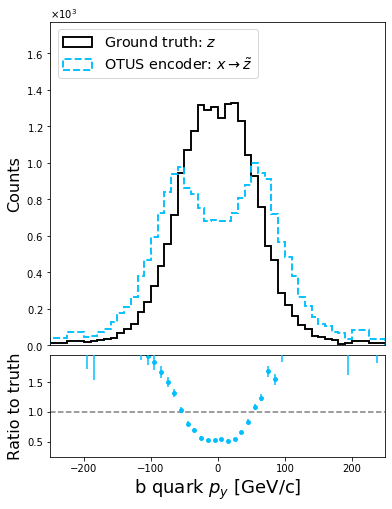

In [20]:
#-- Plot this for the b Quark's py --#
ratioPlotSingle(EPlotData[0][:,9], EPlotData[1][:,9], zbinsList[0], (-250,250), (0,7000), (0.25, 1.95), 
                   r'b quark $p_y$ [GeV/c]', legend=True, save_figs=save_figs, img_dir=img_dir, ablLambda=f'lamb={lamb}') # zStatsList[0],

## Principal Axes Plots x space

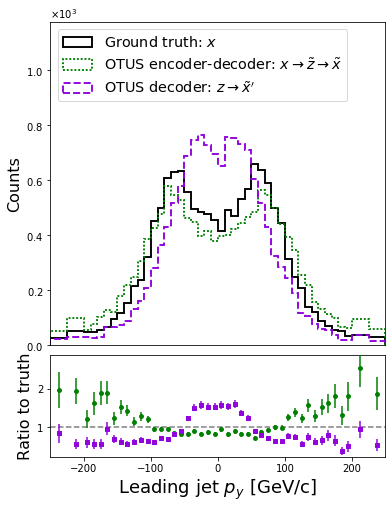

In [21]:
#-- Plot this for the positron's py --#
ratioPlotDouble(DPlotData[0][:,9], DPlotData[1][:,9], DPlotData[2][:,9], xbinsList[0], 
                   (-250,250), (0,7000), (0.25,2.85), 
                   r'Leading jet $p_y$ [GeV/c]', legend=True, save_figs=save_figs, img_dir=img_dir, ablLambda=f'lamb={lamb}') #xStatsList[0], xStatsListTruth[0], 

# Calculate Derived Quantities

## Calculate Invariant Mass Derived Quantities

In x-space, invariant mass checks are somewhat complicated as we don't know which jets correspond to which quarks. There are 5 in total.

1) t tbar pair mass

2) Leptonic W mass

3) Hadronic W mass

4) Leptonic t mass

5) Hadronic t mass

### Import code to calculate these quantities

In [22]:
from top_masses import ttbar_masses

# Note that ttbar_masses(x) where x is a 24-length vector (i.e. one sample from x-space)

### Calculate for x in DPlotData[0] data

In [23]:
# Loop over all events and calculate the masses in each case
xval_massesArr = np.array([ttbar_masses(DPlotData[0][i,:]) for i in range(DPlotData[0].shape[0])])

xval_IM_ttbar, xval_IM_Wlep, xval_IM_Whad, xval_IM_tlep, xval_IM_thad = xval_massesArr[:,0], xval_massesArr[:,1], xval_massesArr[:,2], xval_massesArr[:,3], xval_massesArr[:,4]

### Calculate for $\tilde{x}$ in DPlotData[1] data

In [24]:
# Loop over all events and calculate the masses in each case
xpred_massesArr = np.array([ttbar_masses(DPlotData[1][i,:]) for i in range(DPlotData[1].shape[0])])

xpred_IM_ttbar, xpred_IM_Wlep, xpred_IM_Whad, xpred_IM_tlep, xpred_IM_thad = xpred_massesArr[:,0], xpred_massesArr[:,1], xpred_massesArr[:,2], xpred_massesArr[:,3], xpred_massesArr[:,4]

### Calculate for $\tilde{x}^\prime$ in DPlotData[2] data

In [25]:
# Loop over all events and calculate the masses in each case
xpredtruth_massesArr = np.array([ttbar_masses(DPlotData[2][i,:]) for i in range(DPlotData[2].shape[0])])

xpredtruth_IM_ttbar, xpredtruth_IM_Wlep, xpredtruth_IM_Whad, xpredtruth_IM_tlep, xpredtruth_IM_thad = xpredtruth_massesArr[:,0], xpredtruth_massesArr[:,1], xpredtruth_massesArr[:,2], xpredtruth_massesArr[:,3], xpredtruth_massesArr[:,4]

### Form into lists for compact notation

In [26]:
ttbarPlotData = [xval_IM_ttbar, xpred_IM_ttbar, xpredtruth_IM_ttbar]
WlepPlotData  = [xval_IM_Wlep,  xpred_IM_Wlep,  xpredtruth_IM_Wlep]
WhadPlotData  = [xval_IM_Whad,  xpred_IM_Whad,  xpredtruth_IM_Whad]
tlepPlotData  = [xval_IM_tlep,  xpred_IM_tlep,  xpredtruth_IM_tlep]
thadPlotData  = [xval_IM_thad,  xpred_IM_thad,  xpredtruth_IM_thad]

# Find correct binning for Derived Quantities

## Find correct binning for invariant mass derived quantities

In [27]:
# Want to find bins such that n has no bins with <5 entries
bins_thad = [60] + [100 + 20*i for i in range(38+1)] + [900] #[60 + 20*i for i in range(42+1)]
n, _, _ = plt.hist(thadPlotData[1], bins=bins_thad, histtype='step', density=False)
n, _, _ = plt.hist(thadPlotData[0], bins=bins_thad, histtype='step', density=False)
print("Number of entries in each bin: ",n)
print("Do any bins have less than 5 entries? ",np.any(n < 5))

plt.close() # Don't show plot

Number of entries in each bin:  [  88.  291.  733. 1866. 2784. 1956. 1103.  756.  613.  461.  365.  303.
  235.  239.  197.  153.  171.  140.  105.  116.   86.   64.   65.   75.
   43.   55.   38.   41.   32.   36.   33.   23.   17.   18.   20.   24.
   15.   15.   16.   24.]
Do any bins have less than 5 entries?  False


# Run Statistical Analysis for Derived Quantities

## Run Statistical Analysis for Invariant Mass Derived Quantities

In [28]:
xIMstatsList = []
xIMstatsListTruth = []

# thad
xIMstatsList.append(runStatAnalysis(thadPlotData[1], thadPlotData[0], bins_thad))
xIMstatsListTruth.append(runStatAnalysis(thadPlotData[2], thadPlotData[0], bins_thad))
   

# Make Plots for Derived Quantities

## Make Plots for Invariant Mass Derived Quantities

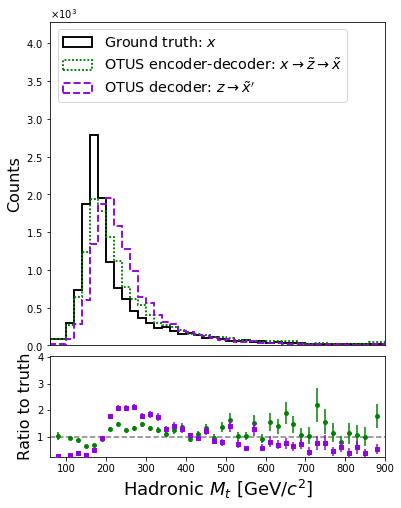

In [29]:
ratioPlotDouble(thadPlotData[0], thadPlotData[1], thadPlotData[2], bins_thad, 
                   (60,900), (0,10000), (0.25,4.05),  
                   r'Hadronic $M_{t}$ [GeV/$c^2$]', legend=True, save_figs=save_figs, img_dir=img_dir, ablLambda=f'lamb={lamb}') #xIMstatsList[4],  xIMstatsListTruth[4], 

# Transport plots

Brief Reminder of Notation:

- TransportPlotData[0] -> [$\tilde{z}$, $\tilde{x}$]
- TransportPlotData[1] -> [$z$, $x$]
- TransportPlotData[2] -> [$z$, $\tilde{x}'$]

Ex.
- $\tilde{z}$ = TransportPlotData[0][0]
- $\tilde{z}$, b quark energy = TransportPlotData[0][0][:,11]
- $\tilde{x}$ = TransportPlotData[0][0]
- $\tilde{x}$, leading jet energy = TransportPlotData[0][1][:,11]

## Decoder $\tilde{z} \rightarrow \tilde{x}$

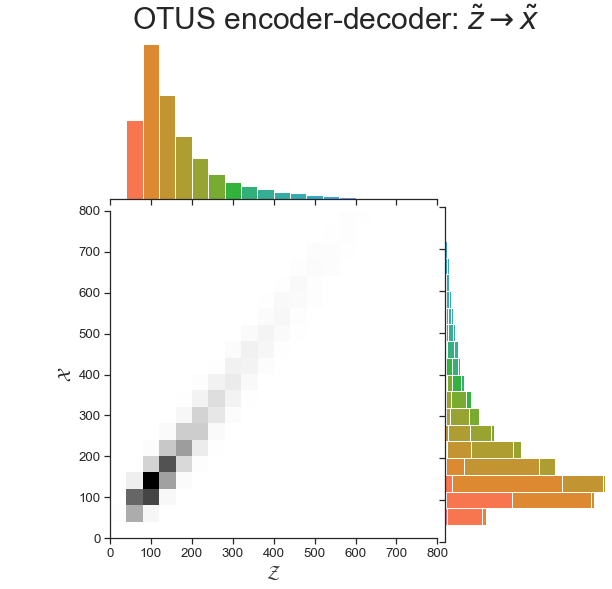

In [30]:
#-- Make decoder transport plot from learned latent space--#

# Leading jet energy
Z = TransportPlotData[0][0][:,11].reshape(-1,1) 
X = TransportPlotData[0][1][:,11].reshape(-1,1) 

n = Z.shape[1]
ZX = [np.concatenate((Z[:,i].reshape(-1,1), X[:,i].reshape(-1,1)), axis=1) for i in range(n)]

transportPlot(ZX[0], zlim=(0, 800), xlim=(0,800), nz=20, nx=20, name=f'decTransport_zpred_xpred_val_lamb={lamb}.png', dec=True, title=r'$\hspace{4}$ OTUS encoder-decoder: $\tilde{z} \rightarrow \tilde{x}$', save_figs=save_figs, img_dir=img_dir)